In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# Load and Explore Data
df = pd.read_csv('bank.csv')  # Adjust separator if needed

In [ ]:
print("Dataset Shape:", df.shape)

Dataset Shape: (41188, 21)


In [ ]:
print("Column Names:", df.columns)

Column Names: Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [ ]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [ ]:
# Step 2: Preprocess Data
# Encode categorical features
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
# Define features and target
X = df.drop(columns=['y'])  # Assuming 'y' is the target column
y = df['y']

In [ ]:
# Feature Selection - Remove low variance features
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)

In [ ]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalize features
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

X_train_positive = scaler_minmax.fit_transform(X_train) + 1e-10  # Shift to positive
X_test_positive = scaler_minmax.transform(X_test) + 1e-10  # Shift to positive

In [ ]:
# Step 3: Train Naïve Bayes Models
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB()
}

initial_results = {}
conf_matrices = {}
for name, model in models.items():
    X_train_input = X_train_scaled if name == "GaussianNB" else X_train_positive
    X_test_input = X_test_scaled if name == "GaussianNB" else X_test_positive
    initial_results[name], conf_matrices[name] = train_and_evaluate(model, X_train_input, X_test_input, y_train, y_test)

print("Initial Model Performance:", initial_results)

Initial Model Performance: {'GaussianNB': {'Accuracy': 0.7766757865937073, 'Precision': 0.7766789114165668, 'Recall': 0.7766757865937073, 'F1 Score': 0.7766728975847771}, 'MultinomialNB': {'Accuracy': 0.7227770177838577, 'Precision': 0.7228110075352214, 'Recall': 0.7227770177838577, 'F1 Score': 0.7227567243675581}, 'BernoulliNB': {'Accuracy': 0.4984952120383037, 'Precision': 0.24849747642511336, 'Recall': 0.4984952120383037, 'F1 Score': 0.33166268991557035}, 'ComplementNB': {'Accuracy': 0.7229822161422709, 'Precision': 0.7230234594050551, 'Recall': 0.7229822161422709, 'F1 Score': 0.7229588694386849}}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Step 4: Hyperparameter Tuning
param_grids = {
    "GaussianNB": {'var_smoothing': np.logspace(-9, 0, 20)},
    "MultinomialNB": {'alpha': np.linspace(0.01, 2.0, 20)},
    "BernoulliNB": {'alpha': np.linspace(0.01, 2.0, 20)},
    "ComplementNB": {'alpha': np.linspace(0.01, 2.0, 20)}
}

tuned_results = {}
best_models = {}
best_params = {}
tuned_conf_matrices = {}
for name, model in models.items():
    X_train_input = X_train_scaled if name == "GaussianNB" else X_train_positive
    X_test_input = X_test_scaled if name == "GaussianNB" else X_test_positive

    grid_search = GridSearchCV(model, param_grids[name], scoring='accuracy', cv=10, n_jobs=-1)
    grid_search.fit(X_train_input, y_train)
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    tuned_results[name], tuned_conf_matrices[name] = train_and_evaluate(best_models[name], X_train_input, X_test_input, y_train, y_test)

print("Best Parameters:", best_params)
print("Tuned Model Performance:", tuned_results)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best Parameters: {'GaussianNB': {'var_smoothing': 1e-09}, 'MultinomialNB': {'alpha': 0.21947368421052632}, 'BernoulliNB': {'alpha': 0.01}, 'ComplementNB': {'alpha': 0.5336842105263158}}
Tuned Model Performance: {'GaussianNB': {'Accuracy': 0.7766757865937073, 'Precision': 0.7766789114165668, 'Recall': 0.7766757865937073, 'F1 Score': 0.7766728975847771}, 'MultinomialNB': {'Accuracy': 0.7227770177838577, 'Precision': 0.7228110075352214, 'Recall': 0.7227770177838577, 'F1 Score': 0.7227567243675581}, 'BernoulliNB': {'Accuracy': 0.4984952120383037, 'Precision': 0.24849747642511336, 'Recall': 0.4984952120383037, 'F1 Score': 0.33166268991557035}, 'ComplementNB': {'Accuracy': 0.7229822161422709, 'Precision': 0.7230234594050551, 'Recall': 0.7229822161422709, 'F1 Score': 0.7229588694386849}}


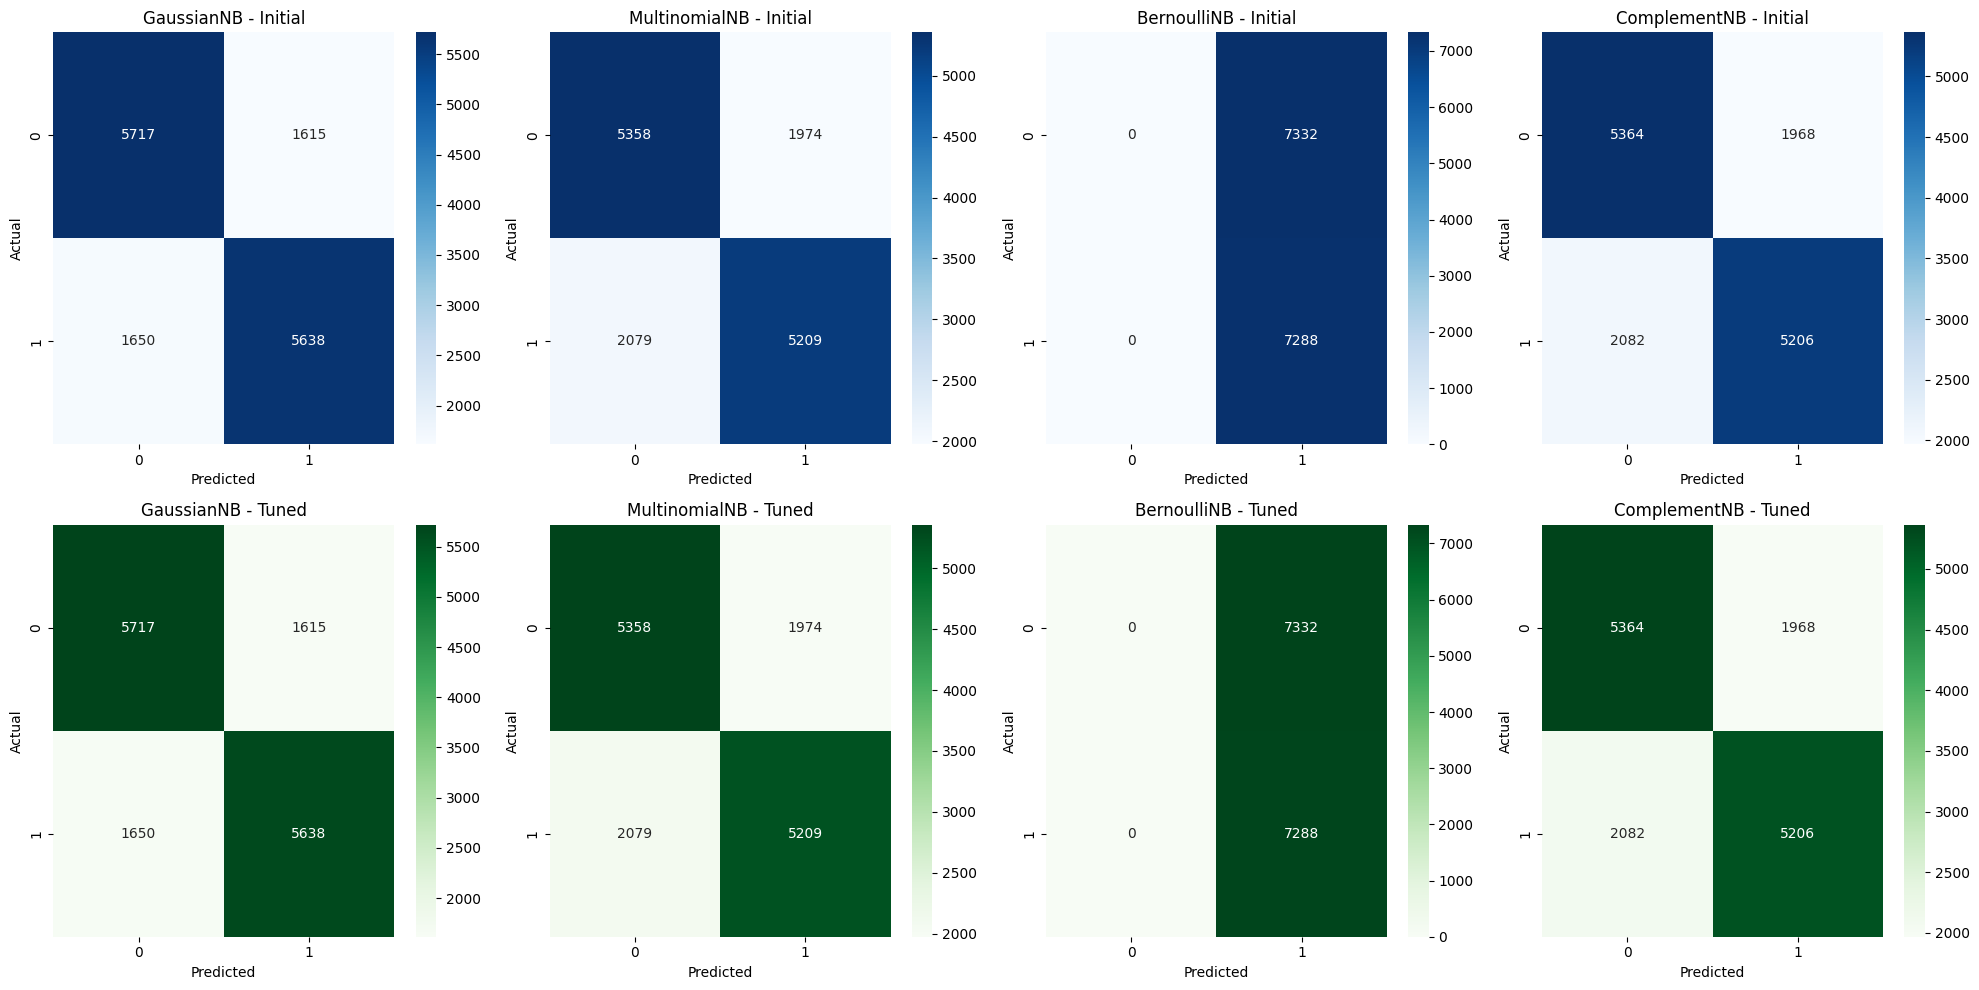

In [ ]:
# Plot Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()
for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} - Initial')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for idx, (name, cm) in enumerate(tuned_conf_matrices.items(), start=4):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[idx])
    axes[idx].set_title(f'{name} - Tuned')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()
